## Import libraries

In [149]:
# import libraries
import data_handler as dh
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
import os
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Display plots inline and change plot resolution to retina
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Set Seaborn aesthetic parameters to defaults
sns.set()

## Get data

In [143]:
data_path = './data/heart.csv'
x_train, x_test, y_train, y_test = dh.get_data(data_path)

## Process Data

In [144]:
#Normalize data
scalar = StandardScaler()
scalar_x_train = scalar.fit_transform(x_train)
scalar_x_test = scalar.transform(x_test)

## Visualization

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   

   caa  thall  output  
0    0      1       1  
1    0      2       1  


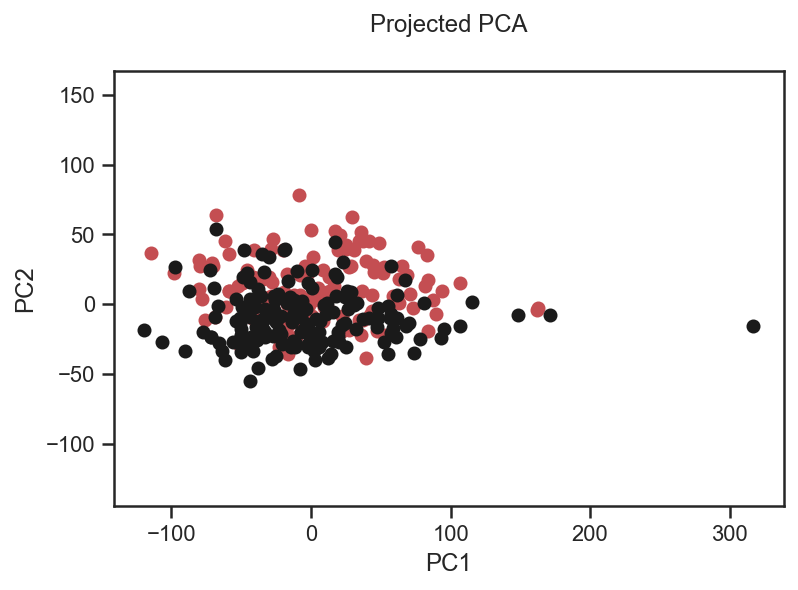

In [172]:
data = pd.read_csv(data_path)
print(data.head(2))

pca = PCA(n_components=2)
x_pca = pca.fit_transform(data.values[:,:-1])

# You should end up with a transformed dataframe
columns = ['pc'+str(i) for i in range(1,pca.n_features_+1)]
df_pca = pd.DataFrame(x_pca)

df_pca_0 = df_pca[data.values[:, -1] == 0]
df_pca_1 = df_pca[data.values[:, -1] == 1]

#visualize with PCA
plt.scatter(df_pca_0.values[:, 0], df_pca_0.values[:, 1], alpha=1,c='r')
plt.scatter(df_pca_1.values[:, 0], df_pca_1.values[:, 1], alpha=1,c='k')
plt.axis('equal');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.title('Projected PCA\n');

## Train Model

 
Train Accuracy: 0.8925619834710744,	Test Accuracy: 0.8688524590163934
F1 Score: 0.8888888888888888,	Precision  Score: 0.8421052631578947,	Recall Score: 0.9411764705882353


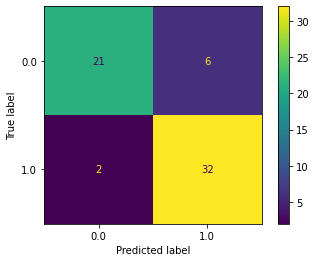

In [145]:
#fit svm
svm_clf_best = svm.SVC()
svm_clf_best.fit(scalar_x_train,y_train)

#check initial accuracy
acc_train = svm_clf_best.score(scalar_x_train,y_train)
acc_test = svm_clf_best.score(scalar_x_test,y_test)
y_pred = svm_clf_best.predict(scalar_x_test)
print(" ")
print("Train Accuracy: {},\tTest Accuracy: {}".format(acc_train,acc_test))
print("F1 Score: {},\tPrecision  Score: {},\tRecall Score: {}".format( f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred) ) )

conf=ConfusionMatrixDisplay.from_estimator(svm_clf_best, scalar_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

## Grid Search on svm

In [14]:
params_more = {'kernel':['linear','rbf','poly','sigmoid'],\
    'C':np.arange(2**(-5),2**5,2),\
        'decision_function_shape':['ovr','ovo'],\
            'gamma':np.arange(2**(-5),2**5,2)}

svc = svm.SVC()
grid_clf = GridSearchCV(svc, params_more, cv=10)
grid_clf.fit(scalar_x_train, y_train)

svm_model = grid_clf.best_estimator_
print("Best estimator found by grid search: "+str(svm_model))

print('\nkernel:\t'+svm_model.kernel+'\nC:\t'+str(svm_model.C)\
    +'\nDecision Function Shape:\t'+svm_model.decision_function_shape\
        +'\nGamma:\t'+str(svm_model.gamma))
print("\nScore:\t"+str(grid_clf.best_score_))

y_pred = svm_model.predict(scalar_x_test)
print(" ")
print("Train Accuracy: {},\tTest Accuracy: {}".format(acc_train,acc_test))
print("F1 Score: {},\tPrecision  Score: {},\tRecall Score: {}".format( f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred) ) )

Best estimator found by grid search: SVC(C=0.03125, gamma=0.03125, kernel='linear')

kernel:	linear
C:	0.03125
Decision Function Shape:	ovr
Gamma:	0.03125

Score:	0.8225


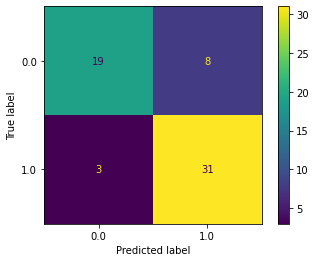

In [90]:
conf=ConfusionMatrixDisplay.from_estimator(grid_clf, scalar_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

## Data Argmentation

Before Samplying: (242, 13)	After Samplying: (262, 13)	Percentage Increase: 0.08264462809917356
0.8931297709923665 0.8688524590163934
 
Train Accuracy: 0.8931297709923665,	Test Accuracy: 0.8688524590163934
F1 Score: 0.8888888888888888,	Precision  Score: 0.8421052631578947,	Recall Score: 0.9411764705882353


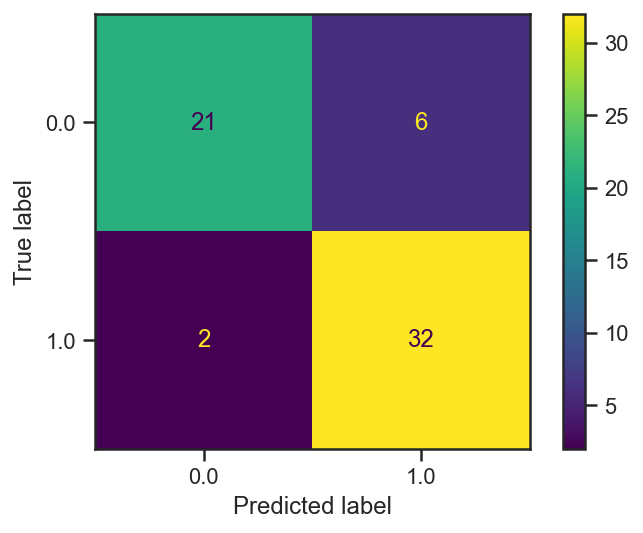

In [177]:
#Over Sampling

sm = SMOTE(random_state=12)

x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
percentage_increase = (x_train_res.shape[0] - x_train.shape[0]) / x_train.shape[0]

print('Before Samplying: {}\tAfter Samplying: {}\tPercentage Increase: {}'.format(x_train.shape, x_train_res.shape, percentage_increase))

#Normalize data
scalar = StandardScaler()
scalar_x_train = scalar.fit_transform(x_train_res)
scalar_x_test = scalar.transform(x_test)

#fit svm
svm_clf = svm.SVC()
svm_clf.fit(scalar_x_train,y_train_res)

#check initial accuracy
acc_train = svm_clf.score(scalar_x_train,y_train_res)
acc_test = svm_clf.score(scalar_x_test,y_test)
print(acc_train,acc_test)

y_pred = svm_clf.predict(scalar_x_test)
print(" ")
print("Train Accuracy: {},\tTest Accuracy: {}".format(acc_train,acc_test))
print("F1 Score: {},\tPrecision  Score: {},\tRecall Score: {}".format( f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred) ) )

conf=ConfusionMatrixDisplay.from_estimator(svm_clf, scalar_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix
#SMOTEENN


Before Samplying: (242, 13)	After Samplying: (79, 13)	Percentage Increase: -0.6735537190082644
0.9873417721518988 0.7868852459016393
 
Train Accuracy: 0.9873417721518988,	Test Accuracy: 0.7868852459016393
F1 Score: 0.8169014084507041,	Precision  Score: 0.7837837837837838,	Recall Score: 0.8529411764705882


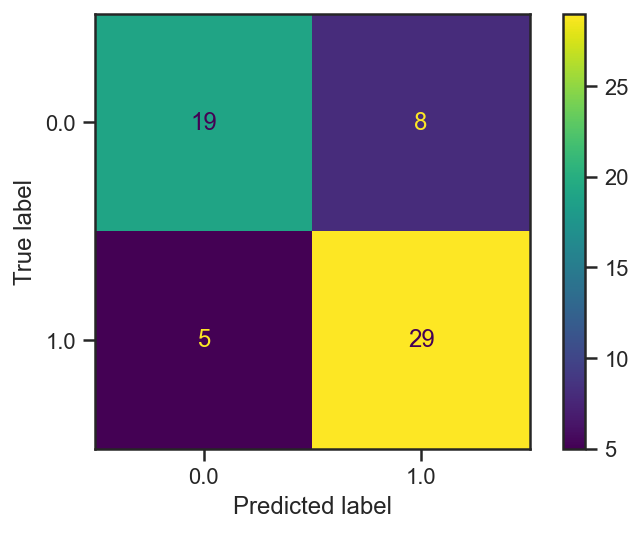

In [179]:
#Under Sampling

sm = SMOTEENN(random_state=12)

x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

percentage_increase = (x_train_res.shape[0] - x_train.shape[0]) / x_train.shape[0]
print('Before Samplying: {}\tAfter Samplying: {}\tPercentage Increase: {}'.format(x_train.shape, x_train_res.shape, percentage_increase))

#Normalize data
scalar = StandardScaler()
scalar_x_train = scalar.fit_transform(x_train_res)
scalar_x_test = scalar.transform(x_test)

#fit svm
svm_clf = svm.SVC()
svm_clf.fit(scalar_x_train,y_train_res)

#check initial accuracy
acc_train = svm_clf.score(scalar_x_train,y_train_res)
acc_test = svm_clf.score(scalar_x_test,y_test)
print(acc_train,acc_test)

y_pred = svm_clf.predict(scalar_x_test)
print(" ")
print("Train Accuracy: {},\tTest Accuracy: {}".format(acc_train,acc_test))
print("F1 Score: {},\tPrecision  Score: {},\tRecall Score: {}".format( f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred) ) )

conf=ConfusionMatrixDisplay.from_estimator(svm_clf, scalar_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix


Before Samplying: (242, 13)	After Samplying: (484, 13)	Percentage Increase: 1.0
 
Train Accuracy: 0.9421487603305785,	Test Accuracy: 0.8852459016393442
F1 Score: 0.8985507246376812,	Precision  Score: 0.8857142857142857,	Recall Score: 0.9117647058823529


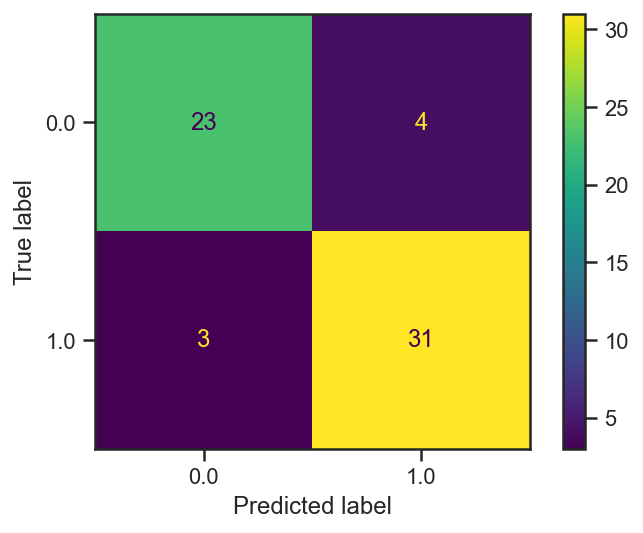

In [178]:
#Generating Data by some STD percentage

random_train = np.random.normal(0,.1,size=x_train.shape) +  x_train
x_train_res = np.concatenate([x_train,random_train],axis=0)
y_train_res = np.concatenate([y_train,y_train],axis=0)

percentage_increase = (x_train_res.shape[0] - x_train.shape[0]) / x_train.shape[0]
print('Before Samplying: {}\tAfter Samplying: {}\tPercentage Increase: {}'.format(x_train.shape, x_train_res.shape, percentage_increase))


#Normalize data
scalar = StandardScaler()
scalar_x_train = scalar.fit_transform(x_train_res)
scalar_x_test = scalar.transform(x_test)

#fit svm
svm_clf = svm.SVC()
svm_clf.fit(scalar_x_train,y_train_res)

#check initial accuracy
acc_train = svm_clf.score(scalar_x_train,y_train_res)
acc_test = svm_clf.score(scalar_x_test,y_test)

y_pred = svm_clf.predict(scalar_x_test)
print(" ")
print("Train Accuracy: {},\tTest Accuracy: {}".format(acc_train,acc_test))
print("F1 Score: {},\tPrecision  Score: {},\tRecall Score: {}".format( f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred) ) )

conf=ConfusionMatrixDisplay.from_estimator(svm_clf, scalar_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix


## Gradient Boost

1.0 0.8032786885245902


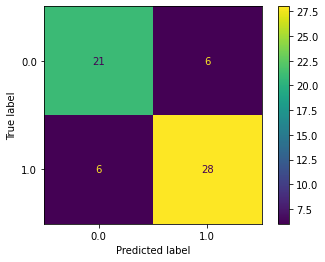

In [94]:
#fit gdb
gdb_clf = GradientBoostingClassifier()
gdb_clf.fit(x_train,y_train)

#check initial accuracy
acc_train = gdb_clf.score(x_train,y_train)
acc_test = gdb_clf.score(x_test,y_test)
print(acc_train,acc_test)

conf=ConfusionMatrixDisplay.from_estimator(gdb_clf, x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

1.0 0.8852459016393442


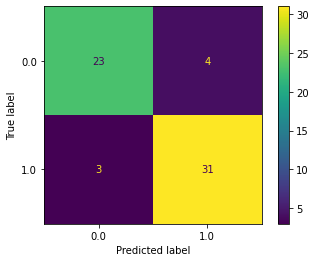

In [95]:
#fit gdb
gdb_clf = RandomForestClassifier()
gdb_clf.fit(x_train,y_train)

#check initial accuracy
acc_train = gdb_clf.score(x_train,y_train)
acc_test = gdb_clf.score(x_test,y_test)
print(acc_train,acc_test)

conf=ConfusionMatrixDisplay.from_estimator(gdb_clf, x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

1.0 0.8360655737704918


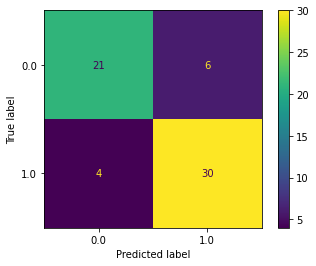

In [124]:
sm = SMOTE(random_state=12)
newx_col = x_train[:,3]-x_train[:,4]
newx_test_col = x_test[:,3]-x_test[:,4]

new_x_test = np.concatenate((x_test,newx_test_col.reshape(-1,1)),axis=1)

nx_train = np.concatenate((x_train,newx_col.reshape(-1,1)),axis=1)

x_train_res, y_train_res = sm.fit_resample(nx_train, y_train)

#fit gdb
gdb_clf = RandomForestClassifier()
gdb_clf.fit(x_train_res,y_train_res)

#check initial accuracy
acc_train = gdb_clf.score(x_train_res,y_train_res)
acc_test = gdb_clf.score(new_x_test,y_test)
print(acc_train,acc_test)

conf=ConfusionMatrixDisplay.from_estimator(gdb_clf, new_x_test, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

In [128]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


1.0 0.7049180327868853


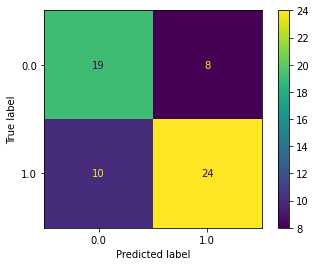

In [129]:

#fit gdb
gdb_clf = RandomForestClassifier()
gdb_clf.fit(x_train_pca,y_train)

#check initial accuracy
acc_train = gdb_clf.score(x_train_pca,y_train)
acc_test = gdb_clf.score(x_test_pca,y_test)
print(acc_train,acc_test)

conf=ConfusionMatrixDisplay.from_estimator(gdb_clf, x_test_pca, y_test);#, display_labels=labels
conf_mat = conf.confusion_matrix

## Retrain Model

In [ ]:
model = GradientBoostingRegressor(random_state=0)
gs = GridSearchCV(model, param_grid, cv=10)
gs = gs.fit(x_train, y_train)

## Check Accuracy

## Choose and Save Best model

In [146]:
#save model
path = './data/best_model.joblib'
try:
    os.remove(path)
except:
    pass
dump(svm_clf_best, path)


['./data/best_model.joblib']